In [1]:
import ibmJupyterNotebookStyles
ibmJupyterNotebookStyles.apply_ibm_styles()

## Get started with finite element simulations for heat transfer problems

In this notebook, the simulation of one-dimensional conductive heat transfer is demonstrated by using the classical finite element method (FEM) combined with the quantum HHL algorithm. This is done through the following steps:
1. Understand the heat transfer problem.<sup>1</sup>
2. Solve the problem with Galerkin finite element method and quantum Harrow-Hassidim-Lloyd (HHL).<sup>2,3,4</sup>
3. Solve the problem with a classical solver.

We chose this simple case of heat transfer as the aim of this notebook to provide a jump-start on how to use and combine the finite element method with quantum HHL. The HHL algorithm is used to solve a system of linear equations arising from the finite element method. From the code in this notebook, you can explore how to apply this method to more complex problems. The description that follows of the finite element method closely follows Schirén 2018 and Kelly 2020.<sup>2,3</sup>

### Problem statement

We focus on the simulation of one-dimensional heat conduction, the process by which heat diffuses through a solid or stationary fluid. The simulation of one-dimensional heat conduction is governed by the homogenous heat equation
$$
\rho C_p \frac{\partial u(x, t)}{\partial t} = \frac{\partial}{\partial x}\bigg(A \kappa \frac{\partial u(x, t)}{\partial x}\bigg)
$$
for the domain $0 \le x \le L$, with boundary conditions $u(0, t)= a$ and $u(L, t) = b$, and initial condition $u(x, 0) = 0$. Here $\rho$ denotes the density, $C_p$ is the heat capacity, $A$ is the cross-sectional area, and $\kappa$ is the conductivity. Hence, this is a specific form of the more general linear diffusion equation.<sup>1</sup> 
<p style="text-align:center;"><img src="heat_conduction1D.png" width=600></p>

This figure shows a schematic representation of one-dimensional conductive heat transfer in a solid. Hence, the one-dimensional problem assumes the radius of the cylinder to be zero, which means we can regard the cylinder as having no significant transverse temperature variation. Furthermore, the cylinder is assumed to be fully isolated along its length, having heat loss only at its uninsulated ends.<sup>1</sup>

#### Galerkin finite element method

Next, we simulate the homogeneous heat equation by combining the finite element method with the quantum HHL algorithm. We use the quantum algorithm HHL to solve the system of linear equations arising from the finite element method. Finite element-based simulations form an integral part of industry workflows. We also discuss the points that need to be considered when such problems are mapped to a quantum computer.

<p style="text-align:center;"><img src="fem_cartoon.jpg" width=800></p>

In this tutorial, we use the Galerkin method, details on which can be found in the standard textbooks on finite element analysis.<sup>3,4</sup>
Here, we discuss the scheme only briefly. In the Galerkin method, as in any other finite element method, 
the domain is divided into finite elements and the function is approximated using trial functions over these elements. 
The boundaries of the elements are referred to as nodes. The basic steps involved are the following:

1) The given differential equation is multiplied on both sides by the weight function $\omega(x)$.<br>
2) If possible, integration by parts is applied to reduce the degree of highest-order terms.<br>
3) An appropriate order of interpolation and weight function is chosen. Usually, the weight function is set as equal to the functions generally referred to as shape functions. Let’s denote this shape function as $N_i(x)$ for the one-dimensional case. The trial solution can then be seen as $u(x) = \sum_{i=1}^{m} N_i(x) u_i,$ where $u_i$ are the unknown coefficients. <br>
4) The resulting equation is then integrated either exactly or numerically.<br>
5) The resuling system of linear equations involving the unknown variables $u_i$ is then solved.<br>

#### Toy example

We quickly discuss here a toy problem involving a single element. Let’s say we want to solve the differential equation
$$\frac{d^2u(x)}{dx^2}=0,$$ 
with $\frac{du(x)}{dx}\big \lvert_{x=1} = 1$ and 
$u(0) = 1$. The analytical solution can be easily derived as $u(x) = x + 1$.

In the Galerkin scheme, we multiply both sides by the weight function, $\omega(x)$, and integrate by parts: 

$$
\begin{aligned}
    & \int_{0}^1 \omega(x) \frac{d^2u(x)}{dx^2} = 0 \\
    & \bigg[\omega(x)\frac{du(x)}{dx}\bigg]_0^1 - \int_{0}^1 \frac{d\omega(x)}{dx} \frac{du(x)}{dx} dx = 0
\end{aligned} \tag{1}
$$

Next, we choose the shape functions at nodes 1 and 2 as $N_1(x) = 1 - x$ and $N_2(x) = x$. Note that the shape functions are chosen in such a 
manner that their sum should equal 1. We then write the trial function $\tilde{u}(x)$ as

$$ 
    \tilde{u}(x) = u_1 N_1(x) + u_2 N_2(x)
$$

Often the weight functions in equation 1 are replaced by the shape functions, that is, $\omega_i(x) = N_i(x)$, where $i \in \{1, 2\}$. 
Inserting these into equation 1, we get

$$
\begin{aligned}
    & \bigg[N_1(x)\frac{d(u_1 N_1(x) + u_2 N_2(x))}{dx}\bigg]_0^1 - \int_{0}^1 \frac{d N_1(x)}{dx} \frac{d(u_1 N_1(x) + u_2 N_2(x))}{dx} dx = 0 \\
    & \bigg[N_2(x)\frac{d(u_1 N_1(x) + u_2 N_2(x))}{dx}\bigg]_0^1 - \int_{0}^1 \frac{d N_2(x)}{dx} \frac{d(u_1 N_1(x) + u_2 N_2(x))}{dx} dx = 0
\end{aligned} \tag{2}
$$

Note that $\frac{d N_1(x)}{dx} = -1$ and $\frac{d N_2(x)}{dx} = 1$. As a result, after solving equation 2, we get $u_2=2 u_1$, 
i.e., $\tilde{u}(x) = c(1 + x)$, where $c$ is some arbitrary constant. Observe that the solution at which we have arrived agrees with the analytical solution.

The heat equation is multiplied by the weight functions for both space and time and then integrated:

$$
\int_0^T \gamma(t) \int_0^L \omega(x) \rho C_p \frac{\partial u(x, t)}{\partial t} dx dt  = \int_0^T \gamma(t) \int_0^L \omega(x) \frac{\partial}{\partial x}\bigg(A \kappa 
                                                                                                    \frac{\partial u(x, t)}{\partial x}\bigg) dx dt
$$

### Implementation

#### Finite element discretization in space

First, let us consider discretization in space. As with the toy problem above, we multiply both sides by the weight function and then 
integrate by parts. Also, for clarity we group all the constants together into $\frac{\rho C_p}{A \kappa} = \eta$. Hence, we get

$$
\eta \int_0^L \omega(x)\frac{\partial u(x, t)}{\partial t} dx = \int_0^L \omega(x) \frac{\partial}{\partial x}\bigg(\frac{\partial u(x, t)}
                                                                                                                    {\partial x}\bigg)
$$

$$
\begin{aligned}
   & \eta \int_0^L \omega(x)\frac{\partial u(x, t)}{\partial t} dx - \bigg[\omega(x) \frac{\partial u(x, t)}{\partial x}\bigg]_0^L
    - \int_{0}^L \frac{d\omega(x)}{dx} \frac{\partial u(x,t)}{\partial x} dx = 0  
\end{aligned}
$$

For the element of length $h$ with nodes at both ends, denoted by indices $i$ and $j$, we define 
$\boldsymbol{N} = [N_i, N_j]$ as a row vector of shape functions. Further, we define $\boldsymbol{u} = [u_i, u_j]^T$ as 
the vector of coefficients when the trial function $\tilde{u}(x, t) = N_i u_i + N_j u_j = \boldsymbol{N}.\boldsymbol{u}$. Also, $\boldsymbol{B}$
is defined as $\partial_x \boldsymbol{N}$. We denote $q = \frac{\partial u(x,t)}{\partial x}$.

After discretization in space, we finally get

$$\eta \int_{0}^{h} \mathbf{N}^{T} \mathbf{N \dot{u}} d x+\int_{0}^{h} \mathbf{B}^{T} \mathbf{B} \boldsymbol{u} d x =
-\left[\mathbf{N}^{T} q\right]_{0}^{h} $$

which can be compactly written as 

$$\eta \mathbf{C}\mathbf{\dot{u}} + \mathbf{K}\mathbf{u}= \mathbf{f}$$

$$
\begin{aligned}
\mathbf{C} &=\int_{0}^{h} \mathbf{N}^{T} \mathbf{N} d x \\
\mathbf{K} &=\int_{0}^{h} \mathbf{B}^{T} \mathbf{B} d x \\
\mathbf{f} &=-\left[\mathbf{N}^{T} q\right]_{0}^{h}
\end{aligned}
$$

$\mathbf{C}, \mathbf{K},$ and $\mathbf{f}$ are usually referred to as the damping matrix, stiffness matrix, and force vector, respectively.
We choose $\boldsymbol{N} = [1 - \frac{x}{h}, \frac{x}{h}]$.

Note that for a single local element, $\boldsymbol{f} = q \begin{pmatrix} 1 \\ -1\end{pmatrix}$ and 
$K = \begin{pmatrix} 1 & -1 \\ -1 & 1\end{pmatrix}$. In order to work with multiple elements, we must consider global versions of
$\mathbf{C}, \mathbf{K},$ and $\mathbf{f}$. For the one-dimensional case, global versions of matrices $\mathbf{C}$ and $\mathbf{K},$ as well as the 
force vector $\mathbf{f}$, are straightforward to obtain and are handled by the function `assemble_matrix` below.

#### Finite element discretization in time

For discretization in time, we consider temperature $\boldsymbol{u_n}$ at time $t_n$ (assumed to be known beforehand) and temperature 
$\boldsymbol{u_{n+1}}$ after time $t_n + \Delta t$. For the given “time-based” finite element, we define a new time $\tau = t - t_n$, 
$0\le \tau \le \Delta t$. 

Starting from $\eta \boldsymbol{C} \boldsymbol{\dot{u}} + \boldsymbol{K} \boldsymbol{u} = \boldsymbol{f}$,
we integrate both sides after multiplying them by the weight function $\gamma(t)$. We choose shape functions for the time discretization as
$$\hat{N}(\tau) = [1-\frac{\tau}{\Delta t}, \frac{\tau}{\Delta t}].$$
Also, we write the time-dependent temperature in terms of shape functions as
$$
\boldsymbol{u}(\tau) = \boldsymbol{\hat{N}_n(\tau)}\boldsymbol{u_n} + \boldsymbol{\hat{N}_{n+1}(\tau)}\boldsymbol{u_{n+1}}
$$

Differentiating both sides with regard to $\tau$ gives us
$$
\begin{aligned}
\boldsymbol{\dot{u}}(\tau) &= \frac{d}{dt} \big(1-\frac{\tau}{\Delta t}\big)\boldsymbol{u_n} +  
\frac{d}{dt} \big(\frac{\tau}{\Delta t}\big)\boldsymbol{u_{n+1}} \\
&= \frac{\boldsymbol{u_{n+1}} - \boldsymbol{u_{n}}}{\Delta t}
\end{aligned}
$$

Inserting the expressions for $\boldsymbol{u}(\tau)$ and $\boldsymbol{\dot{u}}(\tau)$ into 

$$
\begin{aligned}
    \int_0^{\Delta t} \gamma(\tau) \bigg(\eta \boldsymbol{C} \boldsymbol{\dot{u}} + \boldsymbol{K} \boldsymbol{u} - \boldsymbol{f}\bigg) d \tau = 0
\end{aligned}
$$

we get

$$
\begin{aligned}
    \int_0^{\Delta t} \gamma(\tau) \bigg(\eta \boldsymbol{C} \frac{\boldsymbol{u_{n+1}} - \boldsymbol{u_{n}}}{\Delta t} + 
                                         \boldsymbol{K} \big(\big(1-\frac{\tau}{\Delta t}\big)\boldsymbol{u_n} + 
                                         \frac{\tau}{\Delta t}\boldsymbol{u_{n+1}}\big) - \boldsymbol{f}\bigg) d \tau = 0
\end{aligned}
$$

Rearranging terms and dividing both sides by $\int_0^{\Delta t} \gamma(\tau) d \tau$,  we get

$$
\eta \mathbf{C}\left(\frac{\mathbf{u}_{n+1}-\mathbf{u}_n}{\Delta t}\right)+\mathbf{K} \mathbf{u}_n
-\left(\frac{\int_0^{\Delta t} \gamma(\tau) \frac{\tau}{\Delta t} d \tau}{\int_0^{\Delta t} \gamma(\tau) d \tau}\right) \mathbf{K} \mathbf{u}_n
+\left(\frac{\int_0^{\Delta t} \gamma(\tau) \frac{\tau}{\Delta t} d \tau}{\int_0^{\Delta t} \gamma(\tau) d \tau}\right) \mathbf{K} \mathbf{u}_{n+1}
- \mathbf{f} = 0
$$

Denoting 
$$
\Theta = \frac{\int_0^{\Delta t} \gamma(\tau) \frac{\tau}{\Delta t} d \tau}{\int_0^{\Delta t} \gamma(\tau) d \tau},
$$ we write the above equation as

$$
\left(\eta \frac{\mathbf{C}}{\Delta t}+\Theta \mathbf{K}\right) \mathbf{u}_{n+1}=\left(\eta \frac{\mathbf{C}}{\Delta t}-\mathbf{K}(1-\Theta)\right) 
\mathbf{u}_{n}+\mathbf{f}
$$
This could be compactly written as
$$
\mathbf{K^{*}}\mathbf{u}_{n+1} = \mathbf{f}^{*}
$$
$$
\begin{aligned}
\mathbf{K}^{*} &=\frac{\eta \mathbf{C}}{\Delta t}+\Theta \mathbf{K} \\
\mathbf{f}^{*} &=\left(\frac{\eta \mathbf{C}}{\Delta t}-\mathbf{K}(1-\Theta)\right) \mathbf{u}_{n}+\mathbf{f}
\end{aligned}
$$

So basically we have to solve a system of linear equations $\mathbf{K^{*}}\mathbf{u}_{n+1} = \mathbf{f}^{*}$ at each time step. Here, for the 
first time, step $\mathbf{u_1}$, $\mathbf{f^{*}}$ is known. The solution from the previous time step feeds into the next step. Classically, this 
sounds straightforward, but on a quantum computer reading out $\mathbf{u_{n+1}}$ is prohibitively expensive. In order to avoid expensive readouts, we must
do things differently on a quantum computer—for example, working with a “clock” state $|\psi\rangle = 
\frac{1}{\sqrt{N_T}} \sum_{i=1}^{N_T} |u_i\rangle |i\rangle$, where $N_T$ denotes number of time steps. This state keeps the vector $\mathbf{u_i}$ at 
each time step entangled with a time register in superposition. The state at the final time step can then be read out by first reading the time register.
Hence, we work with a bigger system of the form

$$
\begin{pmatrix}
I & 0 & 0 & \cdots & 0 \\
-\left(\frac{\mathbf{C}}{\Delta t}-\mathbf{K}(1-\Theta)\right) & \left(\frac{\mathbf{C}}{\Delta t}+\Theta \mathbf{K}\right) & 0 & \cdots & 0 \\
0 & -\left(\frac{\mathbf{C}}{\Delta t}-\mathbf{K}(1-\Theta)\right) & \left(\frac{\mathbf{C}}{\Delta t}+\Theta \mathbf{K}\right) & \cdots & 0 \\
\vdots & \vdots & \vdots & \ddots & \vdots
\end{pmatrix} \begin{pmatrix}\mathbf{u_1} \\ \mathbf{u_2} \\ \mathbf{u_3} \\ \vdots\end{pmatrix} = \begin{pmatrix} \mathbf{u_1} \\ \mathbf{f} \\ \mathbf{f} \\ \vdots\end{pmatrix}
$$

where we assume that the value of temperature at the first time step $\mathbf{u_1}$ is known. The quantum solver has to invert the bigger matrix to find the
temperature at the last time step.

In this tutorial, we don’t use “clock” states to keep the qubit requirements to a minimum. To avoid the expensive readout for the solution, we use the solution from the classical solver as an input to the quantum solver at each time step. Note that we still compute the relevant output observables using the states obtained from the quantum solver. 

Here, we set
$\rho = 1.0$, $C_p = 1.0$, $A = 1.0$, and $\kappa = 10^{-11}$. Hence, $\eta = \frac{\rho C_p}{A \kappa}=10^{11}.$ We set $\Theta=\frac{2}{3}$ (a choice conventionally taken).

In [2]:
# qiskit imports 
from qiskit.algorithms.linear_solvers.hhl import HHL
from qiskit.quantum_info import Statevector
from qiskit.algorithms.linear_solvers.observables import AbsoluteAverage
from qiskit.algorithms.linear_solvers.numpy_linear_solver import NumPyLinearSolver

import warnings
warnings.filterwarnings('ignore')

The function below assembles the global versions of $\boldsymbol{C}, \boldsymbol{K},$ and $\boldsymbol{f}$, as discussed in the 
theory above.

In [3]:
def assemble_matrix(repeating_matrix, reps):
    """
    Kmatrix or similar for sparsely connected 1D model
    with simple linear topology: o-o-o-o-o
    
    NOTE: Only works with 1D model topology.
    """ 
    outer_mat = np.kron(np.eye(reps), repeating_matrix)
    # will be used with zero border
    inner_mat = np.kron(np.eye(reps-1), repeating_matrix)

    def pad_with(vector, pad_width, iaxis, kwargs):
        pad_value = kwargs.get('padder', 0)
        vector[:pad_width[0]] = pad_value
        vector[-pad_width[1]:] = pad_value
    
    # zero border around inner_mat
    inner_mat0 = np.pad(inner_mat, 1, pad_with)

    return outer_mat + inner_mat0

The following code simulates conduction using both classical and quantum code. Note that the linear system (LS) matrix is Hermitian. We use the HHL quantum algorithm to solve the system of linear equations arising from the finite element method. It is one of the popular quantum algorithms used to solve a system of linear equations. For more details, you can explore the HHL tutorial in Qiskit.<sup>6</sup> We also run a classical solver to compare the results obtained using HHL. 

In [4]:
def classical_xsolver(K_matrix, f_vector, bounds, solver_func):
    """
    Solves a linear system with boundary conditions using a classical solver
    https://github.com/CALFEM/calfem-matlab/blob/master/fem/solveq.m
    """
    dim, dim = K_matrix.shape
    
    bounds = np.array(bounds)
    bounds_idx = bounds[:,0]             # bound indices  "pdof"
    bounds_vec = bounds[:,1]             # bound values (subvector)
    nobound_idx = [x for x in range(dim) if x not in bounds_idx]  # no bounds indices "fdof"

    K_matrix_bounds = K_matrix[np.ix_(nobound_idx, bounds_idx)]      # K_matrix bounds submatrix extraction
    vec = f_vector[nobound_idx] - K_matrix_bounds.dot(bounds_vec)    # build vector  
    K_matrix_nobounds = K_matrix[np.ix_(nobound_idx, nobound_idx)]   # K_matrix nonbounds submatrix extraction
    
    # matrices are hermitian
    # normalize
    vec_norm = np.linalg.norm(vec)
    vec = vec / vec_norm
    
    soln_nobounds = solver_func(K_matrix_nobounds, vec)  # solve Ax=b for x
    obs = NumPyLinearSolver().solve(K_matrix_nobounds, vec, AbsoluteAverage())
    
    # Build solution vector
    soln_vector = np.zeros(dim, dtype=complex)
    soln_vector[bounds_idx] = bounds_vec
    soln_vector[nobound_idx] = soln_nobounds           
    
    return soln_vector, obs.observable



def quantum_xsolver(K_matrix, f_vector, bounds):
    """
    Solves a linear system with boundary conditions using HHL
    https://github.com/CALFEM/calfem-matlab/blob/master/fem/solveq.m
    
    """
    dim, dim = K_matrix.shape
    
    bounds = np.array(bounds)
    bounds_idx = bounds[:,0]             # bound indices  "pdof"
    bounds_vec = bounds[:,1]             # bound values (subvector)
    nobound_idx = [x for x in range(dim) if x not in bounds_idx]  # no bounds indices "fdof"

    K_matrix_bounds = K_matrix[np.ix_(nobound_idx, bounds_idx)]      # K_matrix bounds submatrix extraction
    vec = f_vector[nobound_idx] - K_matrix_bounds.dot(bounds_vec)    # build vector  
    K_matrix_nobounds = K_matrix[np.ix_(nobound_idx, nobound_idx)]   # K_matrix nonbounds submatrix extraction
    
    # matrices are hermitian
    # normalize
    vec_norm = np.linalg.norm(vec)
    vec = vec / vec_norm
    K_matrix_nobounds = K_matrix_nobounds 
    
    # this is where quantum linear system is solved by HHL
    hhl_soln = HHL(epsilon=0.01).solve(K_matrix_nobounds, vec, observable=AbsoluteAverage())
    hhl_circuit_state = hhl_soln.state
    obs = hhl_soln.observable
    norm = hhl_soln.euclidean_norm
    
    b_regs_size = hhl_circuit_state.qregs[0].size
    eigval_reg_size = hhl_circuit_state.qregs[1].size
    anc_reg_size = hhl_circuit_state.qregs[2].size
    
    hhl_circuit_vector = Statevector(hhl_soln.state).data
    soln_vec_final = hhl_circuit_vector[-2 ** b_regs_size:]
    
    # correctly scale the output vector
    soln_vec_final = soln_vec_final/np.linalg.norm(soln_vec_final) 
    
    # Build solution vector
    soln_vector = np.zeros(dim, dtype=complex)
    soln_vector[bounds_idx] = bounds_vec
    soln_vector[nobound_idx] = soln_vec_final 
    
    return soln_vector, obs, norm    

In [5]:
# Conduction simulation - classical and quantum
# 1D Finite Element Model for Transient Heat Transfer
from qiskit.circuit import QuantumCircuit

import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from numpy.linalg import solve as npsolve

# -----------Input data---------------
eta = 1e11                 #eta 
noe = 9                    # Nr of elements
non = noe+1                # Nr of nodes
notv = 7                   # Nr of timesteps
T = 7.5e+11                # Total time
dT = T/notv                # Timestep
L = np.pi                  # Total length
elLength = L/noe           # Element length
Theta = 2/3                # Capital theta, 0 ≤ Theta ≤ 1;
inTemp = 1                 # Initial temperature at left hand side, bc
outTemp = 0                # Initial temperature at right hand side, bc


# FEM
# -----------Boundary conditions and empty matrices----------------
# Boundary conditions, at node 1 temp 1 C , last node = 0 C
bc = [[0, inTemp], [noe, outTemp]]               # Boundary cond temperatures at first and last nodes
un_q = np.zeros((non, 1), dtype=complex)
un_c = np.zeros((non, 1), dtype=complex)

# -----------Spatial domain---------------
# element submatrices for the elements
Ke = (1/elLength) * np.array([[1, -1], [-1, 1]])          # Element stiffness
Ce = (eta * elLength/6) * np.array([[2, 1], [1, 2]])      # Element damping

# -----------Global matrices--------------
# construct global matrices
reps = int(non/2)
K = assemble_matrix(Ke, reps)
C = assemble_matrix(Ce, reps)

K_star = (C/dT) + (Theta * K)            # Global stiffness with respect to time
f_star_mat = (C/dT) - K * (1-Theta)

# initialize vector and results matrix
un_q = np.zeros((non, 1))
un_c = np.zeros((non, 1))

#stores expectation value
obs_list_q = []
obs_list_c = []

# stores norm 
norm_list_q = []
norm_list_c = []

# quantum results matrix
RQ_matrix = np.zeros((non, notv), dtype=complex)
# -----------Time step zero---------------
RQ_matrix[:,0] = un_c.reshape((non,))      #  Add the initial temperatures to the first column of A matrix
RQ_matrix[0,0] = 1                       #  Add the boundary condition

# classical results matrix
RC_matrix = np.zeros((non, notv), dtype=complex) 
# -----------Time step zero---------------
RC_matrix[:,0] = un_q.reshape((non,))      #  Add the initial temperatures to the first column of A matrix
RC_matrix[0,0] = 1                       #  Add the boundary condition

# Time evolution
# notv is number of time steps
for i in range(notv-1): 
    
    f_star_q = f_star_mat.dot(un_q)        # Global damping with respect to time
    f_star_q = np.reshape(f_star_q, -1)
    
    f_star_c = f_star_mat.dot(un_c)        # Global damping with respect to time
    f_star_c = np.reshape(f_star_c, -1)

    un1_q, obs_q, norm_q = quantum_xsolver(K_star, f_star_c, bc)   # Temperature in each node at time n+1
    RQ_matrix[:, i+1] = un1_q.reshape((non,))              # Store the temperatures in column i+1
    un_q = deepcopy(un1_q)
    
    un1_c, obs_c = classical_xsolver(K_star, f_star_c, bc, npsolve)   # Temperature in each node at time n+1
    RC_matrix[:, i+1] = un1_c.reshape((non,))        # Store the temperatures in column i+1
    un_c = deepcopy(un1_c)
    norm_c = np.linalg.norm(un1_c)
    
    obs_list_q.append(obs_q)
    obs_list_c.append(obs_c)
    
    norm_list_q.append(norm_c)
    norm_list_c.append(norm_q)

Here, we obtain the observable $\frac{1}{N}\lvert \sum_i x_i\rvert$ at each time step using the `AbsoluteAverage` method in Qiskit. In our case,
the observable corresponds to the average temperature (averaged over the x-dimension). The plot below shows how such an average evolves over time.
As expected, the average temperature levels off after the steady state is reached.

Text(0.5, 0, 'Time steps')

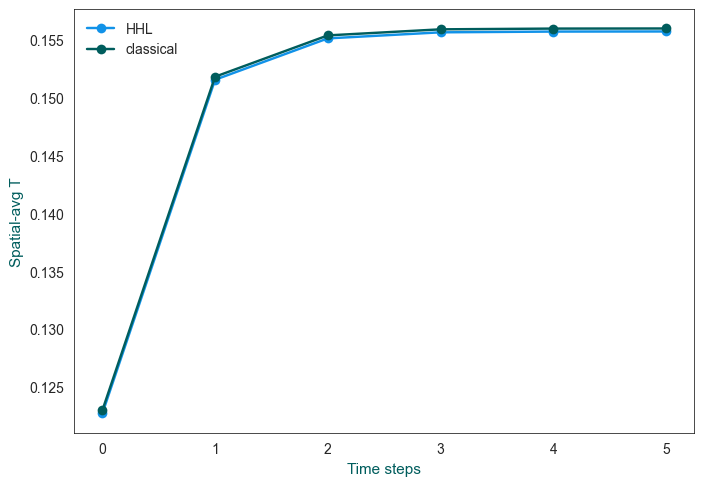

In [6]:
plt.plot(obs_list_q, '-o')
plt.plot(obs_list_c, '-o')
plt.legend(['HHL', 'classical'])
plt.ylabel('Spatial-avg T')
plt.xlabel('Time steps')

### Summary
In this tutorial, we showed how to simulate one-dimensional heat transfer by using the Galerkin finite element method in combination with the HHL algorithm. By applying the Galerkin finite element method, we obtained a linear system of equations. This was the result of discretizing the problem in space and time. Finally, we showed that the linear system could be solved by the quantum HHL algorithm.

Potential next steps include the following:

* Introducing other modes of heat transfer and nonlinear terms into the equation
* Working with problems that involve more than one dimension

### References
1. <a name="1"></a>Peter J. Olver. *Introduction to Partial Differential Equations.* Minneapolis, MN: Springer, 2014. https://doi.org/10.1007/978-3-319-02099-0.

2. <a name="2"></a> Whokko Schirén, *Finite Element Method for 1D Transient Convective Heat Transfer Problems*. June 24, 2018. https://www.diva-portal.org/smash/get/diva2:1223250/FULLTEXT01.pdf.

3. <a name="3"></a>P. Kelly. *The Finite Element Method (FEM)*. 2020. https://pkel015.connect.amazon.auckland.ac.nz/SolidMechanicsBooks/FEM/index.html.

5. <a name="4"></a>Niels Ottosen and Hans Petersson. *Introduction to Finite Element Method.* New Jersey: Pearson, 1992.

6. <a name="5"></a>“Solving Linear Systems of Equations Using HHL.” *Qiskit*. https://qiskit.org/textbook/ch-applications/hhl_tutorial.html.

<span style="font-size:10pt; font-weight:bold;" class = "copyright-content"> &copy; Copyright IBM Corp. 2023 <br/>This content is categorized as an “existing” IBM asset as part of the IBM Quantum Accelerator contract. </span>